In [ ]:
from __future__ import division
from collections import defaultdict, OrderedDict
from copy import deepcopy
#import simuOpt
#simuOpt.setOptions(alleleType='long', optimized=True, quiet=False)

import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt

import simuPOP as sp
from simuPOP import demography
%matplotlib inline
import networkx as nx
import logging as log
import numpy as np

simuPOP Version 1.1.9 : Copyright (c) 2004-2016 Bo Peng
Revision 4583 (Oct 10 2018) for Python 3.7.0 (64bit, 0thread)
Random Number Generator is set to mt19937 with random seed 0xa1a585abe454c670.
This is the standard short allele version with 256 maximum allelic states.
For more information, please visit http://simupop.sourceforge.net,
or email simupop-list@lists.sourceforge.net (subscription required).


In [2]:

class NetworkModel(object):
    """
    NetworkModel implements a full "demographic model" in simuPOP terms,
    that is, it manages the size and existence of subpopulations, and the
    migration matrix between them.  The basic data for this model is derived
    by importing a NetworkX network in the form of a GML format file.
    The network edges represent a set of subpopulations
    with unique ID's, and edges between them which are weighted.  The
    weights may be determined by any underlying model (e.g., distance,
    social interaction hierarchy, etc), but need to be interpreted here
    purely as the probability of individuals moving between two subpopulations,
    since that is the implementation of interaction.
    """

    def __init__(self,
                 networkmodel=None,
                 simulation_id=None,
                 sim_length=10000,
                 burn_in_time=0,
                 initial_subpop_size = 0,
                 migrationfraction = 0.05):
        """
        :param networkmodel: Name of GML file
        :param sim_length: Number of generations to run the simulation
        :return:
        """
        #BaseMetapopulationModel.__init__(self, numGens = sim_length, initSize = initial_size, infoFields = info_fields, ops = ops)
        self.networkmodel = networkmodel
        self.sim_length = sim_length
        self.info_fields = 'migrate_to'
        self.sim_id = simulation_id
        self.burn_in_time = burn_in_time
        self.init_subpop_size = initial_subpop_size
        self.migration_fraction = migrationfraction

        self._cached_migration_matrix = None

        # This will be set when we examine the network model
        self.sub_pops = 0

        self.subpopulation_names = []

        # Parse the GML files and create a list of NetworkX objects
        self._parse_network_model()


        # Determine the initial population configuration
        self._calculate_initial_population_configuration()

        # prime the migration matrix
        self._cached_migration_matrix = self._calculate_migration_matrix()

    ############### Private Initialization Methods ###############

    def _parse_network_model(self):
        """
        Given a file,  read the GML files (format: <name>.gml)
        and construct aNetworkX networkmodel from the GML file
        """

        log.debug("Opening  GML file %s:",  self.networkmodel)
        network = nx.read_gml(self.networkmodel)
        log.debug("network nodes: %s", '|'.join(sorted(network.nodes())))
        self.network = network

    def _calculate_initial_population_configuration(self):
        # num subpops is just the number of vertices in the first graph slice.
        #first_time = min(self.times)
        network = self.network
        self.sub_pops = network.number_of_nodes()
        log.debug("Number of initial subpopulations: %s", self.sub_pops)
        log.debug("list of nodes: %s", list(network.nodes(data=True)))
        # subpoplation names - have to switch them to plain strings from unicode or simuPOP won't use them as subpop names
        self.subpopulation_names =  list(network.nodes)

        log.debug("calc_init_config:  subpopulation names: %s", self.subpopulation_names)


    ############### Private Methods for Call() Interface ###############


    def _get_node_label(self,g, id):
        return g.node[id]["label"].encode('utf-8', 'ignore')


    def _get_id_for_subpop_name(self,pop,name):
        return pop.subPopByName(name)

    def _get_node_parent(self,g, id):
        return g.node[id]["parent_node"].encode('utf-8', 'ignore')


    def _get_subpop_idname_map(self, pop):
        names = pop.subPopNames()
        name_id_map = dict()
        for name in names:
            id = pop.subPopByName(name)
            name_id_map[id] = name
        return name_id_map


    def _calculate_migration_matrix(self):

        g_mat = nx.to_numpy_matrix(self.network).astype(np.float)
        print("g_mat: ", g_mat)
        # get the column totals
        rtot = np.sum(g_mat, axis = 1)
        scaled = (g_mat / rtot) * self.migration_fraction
        diag = np.eye(np.shape(g_mat)[0]) * (1.0 - self.migration_fraction)
        g_mat_scaled = diag + scaled
        log.debug("scaled migration matrix: %s", g_mat_scaled.tolist())
        return g_mat_scaled.tolist()


    ###################### Public API #####################

    def get_info_fields(self):
        return self.info_fields

    def get_initial_size(self):
        return [self.init_subpop_size] * self.sub_pops

    def get_subpopulation_names(self):
        return self.subpopulation_names

    def get_subpopulation_sizes(self):
        return self.subpop_sizes


    def __call__(self, pop):
        """
        Main public interface to this demography model.  When the model object is called in every time step,
        this method creates a new migration matrix.

        After migration, the stat function is called to inventory the subpopulation sizes, which are then
        returned since they're handed to the RandomSelection mating operator.

        If a new network slice is not active, the migration matrix from the previous step is applied again,
        and the new subpopulation sizes are returns to the RandomSelection mating operator as before.

        :return: A list of the subpopulation sizes for each subpopulation
        """
        if 'gen' not in pop.vars():
            gen = 0
        else:
            gen = pop.dvars().gen

        ######### Do the per tick processing ##########

        log.debug("========= Processing network  =============")
        #self._dbg_slice_pop_start(pop,gen)

        # update the migration matrix
        self._cached_migration_matrix = self._calculate_migration_matrix(gen)

        sp.migrate(pop, self._cached_migration_matrix)
        sp.stat(pop, popSize=True)
        # cache the new subpopulation names and sizes for debug and logging purposes
        # before returning them to the calling function
        self.subpopulation_names = sorted(pop.subPopNames())
        self.subpop_sizes = pop.subPopSizes()
        return pop.subPopSizes()


In [18]:
num_loci = 10
pop_size = 5000
num_gens = 1000
num_pops = 5
sub_pop_size= [1000,1000,1000,1000,1000] #int(pop_size/num_pops)
print(sub_pop_size)
migs = [0.001, 0.01, 0.1]
innovation_rate = 0.01
MAXALLELES = 256

[1000, 1000, 1000, 1000, 1000]


In [19]:
init_ops = OrderedDict()
pre_ops = OrderedDict()
post_ops = OrderedDict()

In [20]:
def init_acumulators(pop, param):
    acumulators = param
    for acumulator in acumulators:
        if acumulator.endswith('_sp'):
            pop.vars()[acumulator] = defaultdict(list)
        else:
            pop.vars()[acumulator] = []
    return True

def update_acumulator(pop, param):
    acumulator, var = param
    if  var.endswith('_sp'):
        for sp in range(pop.numSubPop()):
            pop.vars()[acumulator][sp].append(deepcopy(pop.vars(sp)[var[:-3]]))
    else:
        pop.vars()[acumulator].append(deepcopy(pop.vars()[var]))
    return True


In [21]:
#pops = sp.Population([pop_size] * num_pops, loci=[1] * num_loci, infoFields=['migrate_to'])


# Construct a demographic model from a collection of network slices which represent a temporal network
# of changing subpopulations and interaction strengths.  This object is Callable, and simply is handed
# to the mating function which applies it during the copying process
networkmodel = NetworkModel( networkmodel="/Users/clipo/Documents/PycharmProjects/RapaNuiSim/notebooks/test_graph.gml",
                                     simulation_id="1",
                                     sim_length=3000,
                                     burn_in_time=500,
                                     initial_subpop_size=1000,
                                     migrationfraction=0.01)

# The regional network model defines both of these, in order to configure an initial population for evolution
# Construct the initial population

pops = sp.Population(size = networkmodel.get_initial_size(),
                     subPopNames = list(networkmodel.get_subpopulation_names()),
                     infoFields = 'migrate_to',
                     ploidy=1,
                     loci=100 )


g_mat:  [[0. 1. 0. 0. 1.]
 [1. 0. 1. 1. 1.]
 [0. 1. 0. 1. 1.]
 [0. 1. 1. 0. 1.]
 [1. 1. 1. 1. 0.]]


In [22]:
divisor = 100.0 / num_loci
frac = divisor / 100.0
distribution = [frac] * num_loci

init_ops['acumulators'] = sp.PyOperator(init_acumulators, param=['fst'])
init_ops['Sex'] = sp.InitSex()
init_ops['Freq'] = sp.InitGenotype(freq=distribution)
post_ops['Innovate']=sp.KAlleleMutator(k=MAXALLELES, rates=innovation_rate, loci=sp.ALL_AVAIL)
for i, mig in enumerate(migs):
    post_ops['mig-%d' % i] = sp.Migrator(demography.migrIslandRates(mig, num_pops), reps=[i])
post_ops['Stat-fst'] = sp.Stat(structure=sp.ALL_AVAIL)
post_ops['fst_acumulation'] = sp.PyOperator(update_acumulator, param=('fst', 'F_st'))


In [23]:
#mating_scheme = sp.RandomSelection()
mating_scheme=sp.RandomSelection(subPopSize=sub_pop_size)

In [9]:
sim = sp.Simulator(pops, rep=len(migs))
sim.evolve(initOps=list(init_ops.values()), preOps=list(pre_ops.values()), postOps=list(post_ops.values()),
           matingScheme=mating_scheme, gen=num_gens)    

ValueError: mating.cpp: 1298 number of subPopulaitons must agree.
 Pre: 5 now: 1

In [1]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
for pop, mig in zip(sim.populations(), migs):
    ax.plot(pop.dvars().fst, label='mig rate %.4f' % mig)
ax.legend(loc=2)
ax.set_ylabel('FST')
ax.set_xlabel('Generation')



NameError: name 'plt' is not defined

AttributeError: '_dw' object has no attribute 'gst'

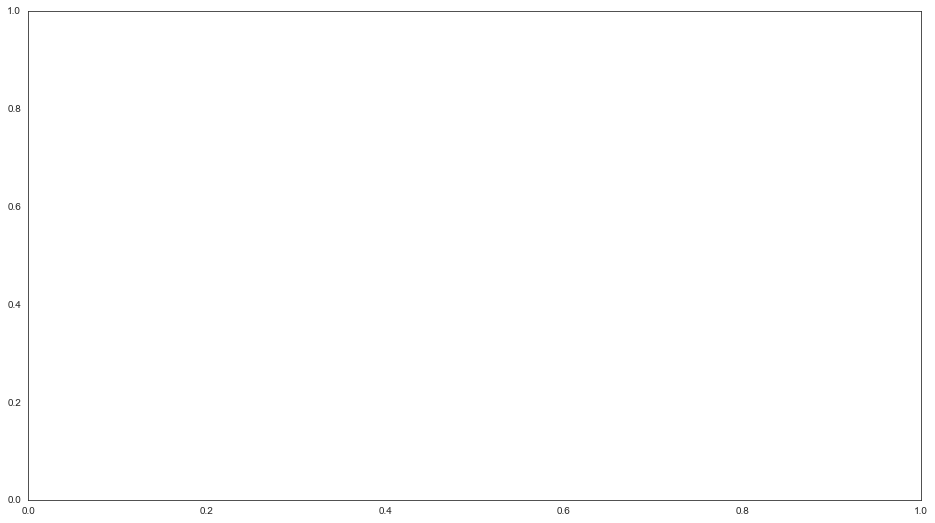

In [22]:
fig2 = plt.figure(figsize=(16, 9))
ax2 = fig2.add_subplot(111)
for pop, mig in zip(sim.populations(), migs):
    ax.plot(pop.dvars().gst, label='mig rate %.4f' % mig)
ax.legend(loc=2)
ax.set_ylabel('GST')
ax.set_xlabel('Generation')

In [26]:
num_gens = 400
num_loci = 5
init_ops = OrderedDict()
pre_ops = OrderedDict()
post_ops = OrderedDict()

init_ops['Sex'] = sp.InitSex()
init_ops['Freq'] = sp.InitGenotype(freq=[0.5, 0.5])
post_ops['Stat-freq'] = sp.Stat(alleleFreq=sp.ALL_AVAIL, vars=['alleleFreq', 'alleleFreq_sp'])
init_ops['acumulators'] = sp.PyOperator(init_acumulators, param=['allele_freq', 'allele_freq_sp'])
post_ops['freq_acumulation'] = sp.PyOperator(update_acumulator, param=('allele_freq', 'alleleFreq'))
post_ops['freq_sp_acumulation'] = sp.PyOperator(update_acumulator,
                                                param=('allele_freq_sp', 'alleleFreq_sp'))

In [27]:
for i, mig in enumerate(migs):
    post_ops['mig-%d' % i] = \
        sp.Migrator(demography.migrSteppingStoneRates(mig, num_pops), reps=[i])
#two 2 - talk
pops = sp.Population([pop_size] * num_pops, 
                     loci=[1] * num_loci, infoFields=['migrate_to'])

In [28]:
sim = sp.Simulator(pops, rep=len(migs))
sim.evolve(initOps=list(init_ops.values()), 
           preOps=list(pre_ops.values()),
           postOps=list(post_ops.values()),
           matingScheme=mating_scheme, gen=num_gens)

RuntimeError: RandomParentsChooser fails because there is no female individual in a subpopulation 

AttributeError: '_dw' object has no attribute 'allele_freq'

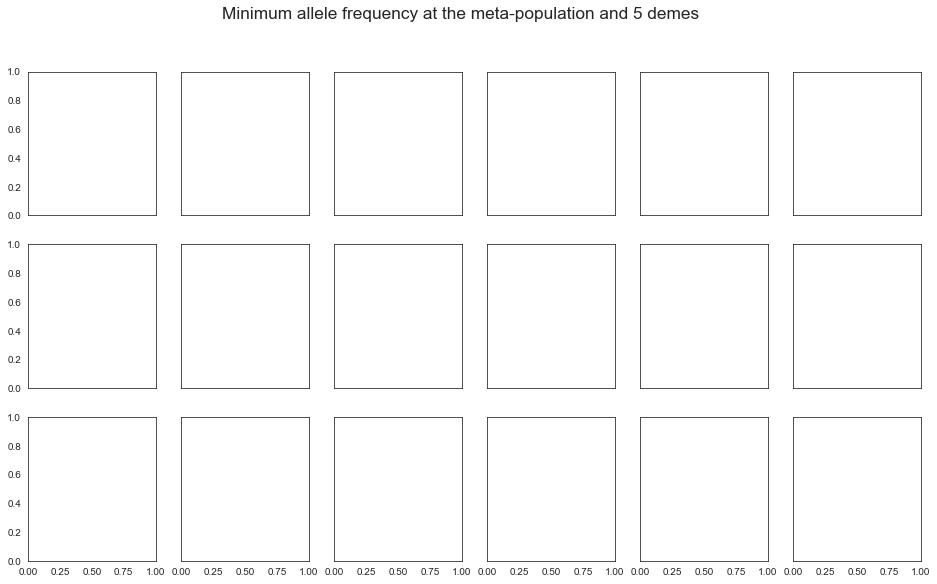

In [20]:
def get_maf(var):
    locus_data = [gen[locus] for gen in var]
    maf = [min(freq.values()) for freq in locus_data]
    maf = [v if v != 1 else 0 for v in maf]
    return maf
    
fig, axs = plt.subplots(3, num_pops // 2 + 1, figsize=(16, 9), sharex=True, sharey=True, squeeze=False)
fig.suptitle('Minimum allele frequency at the meta-population and 5 demes', fontsize='xx-large')
for line, pop in enumerate([sim.population(0), sim.population(1), sim.population(len(migs) - 1)]):
    for locus in range(num_loci):
        maf = get_maf(pop.dvars().allele_freq)
        axs[line, 0].plot(maf)
        axs[line, 0].set_axis_bgcolor('black')
    for nsp in range(num_pops // 2):
        for locus in range(num_loci):
            maf = get_maf(pop.dvars().allele_freq_sp[nsp * 2])
            axs[line, nsp + 1].plot(maf)
fig.subplots_adjust(hspace=0, wspace=0)

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
#G = nx.watts_strogatz_graph(10,1,.01)
G = nx.petersen_graph()
plt.subplot(111)
nx.draw(G, with_labels=True, font_weight='bold')
%matplotlib inline